In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.svm import SVC

from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

plt.style.use('ggplot')

# Preprocessing

In [28]:
# Importing data and defining colors
df = pd.read_csv('2021MCMProblemC_DataSet.csv')
classes = ['Positive ID', 'Negative ID', 'Unverified', 'Unprocessed']
colors = [['orange', 'teal', 'tab:pink', 'tab:brown'], ['red', 'blue', 'tab:purple', 'brown']]

# Removing positive and negative cases for binary classification
df_negative = df.loc[df['Lab Status'] == 'Negative ID']
df_positive = df.loc[df['Lab Status'] == 'Positive ID']
df_negative['Label'] = 0
df_positive['Label'] = 1
print(len(df_negative))
print(len(df_positive))
df = pd.concat([df_negative, df_positive])

# Feature engineering the dates to form features!
# ============= feature engineer with common words?? ==============
df['Detection Date'] = pd.to_datetime(df['Detection Date'], errors = 'coerce')
df['Submission Date'] = pd.to_datetime(df['Submission Date'], errors = 'coerce')
df['D_Day'] = df['Detection Date'].dt.day
df['D_Month'] = df['Detection Date'].dt.month
df['D_Year'] = df['Detection Date'].dt.year
df['S_Day'] = df['Submission Date'].dt.day
df['S_Month'] = df['Submission Date'].dt.month
df['S_Year'] = df['Submission Date'].dt.year

# Create y set and remove unnessary features
y = pd.DataFrame(df['Label'], columns=['Label'])
df = df.drop(['GlobalID', 'Lab Status', 'Lab Comments', 'Detection Date', 'Submission Date', 'Label'], axis=1)

2069
14


In [29]:
y.tail(15)

,Label
4423,0
0,1
1,1
3,1
834,1
924,1
956,1
1011,1
1069,1
3279,1


## Vectorizing Words

In [30]:
# Vectorize Descriptions from users
vectorizer = CountVectorizer(stop_words='english')
word_matrix = vectorizer.fit_transform(df['Notes'])

In [31]:
df = df.drop(['Notes'], axis=1)
df = np.array(df)
words = vectorizer.get_feature_names()
words.extend(('Latitude','Longitude', 'd1', 'm1', 'y1', 'd2', 'm2', 'y2'))
X = np.concatenate([word_matrix.toarray(), df], axis=1)
df = pd.DataFrame(X, columns=words)

df.head()

,00,0038,00am,00pm,07,09,0930,0ave,10,100,...,zoome,zoomed,Latitude,Longitude,d1,m1,y1,d2,m2,y2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,48.729596,-122.480035,29.0,2.0,2020.0,29.0,2.0,2020.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,47.395721,-123.105188,7.0,9.0,2019.0,18.0,3.0,2020.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,47.840041,-122.323562,19.0,3.0,2020.0,19.0,3.0,2020.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,47.635058,-122.057332,30.0,8.0,2019.0,19.0,3.0,2020.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,48.743610,-122.439050,23.0,3.0,2020.0,24.0,3.0,2020.0


In [32]:
# Scale and Normalize
scaler = RobustScaler()
norm = Normalizer()
X = scaler.fit_transform(df)
X = np.where(np.isfinite(X), X, 0)
X = norm.fit_transform(X)

## Fix Dimensionality with PCA

In [33]:
X.shape

(2083, 2933)

In [35]:
# Reducing dimensionality to around 80 features
dim = 80
model_pca = PCA(n_components=dim, random_state=42)
pca_m = model_pca.fit(X)
X = pca_m.transform(X)

In [36]:
X.shape

(2083, 80)

# Training the Model

X's shape: (2083, 80) y's shape: (2083, 1)


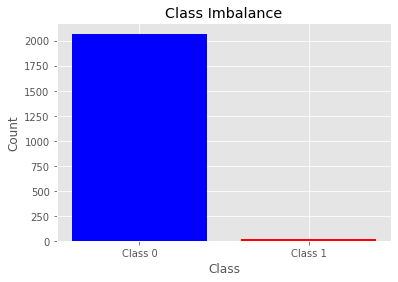

In [37]:
print(f'X\'s shape: {X.shape} y\'s shape: {y.shape}')
num_class0 = len(y[y['Label'] == 0])
num_class1 = len(y[y['Label'] == 1])
plt.bar([0, 1], [num_class0, num_class1], color=['blue', 'red'])
plt.xlabel('Class')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()

In [64]:
# Splitting up the data in test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

# Classifier
clf = SGDClassifier(loss='hinge', penalty='l2',
	alpha=1e-6, random_state=42,
	max_iter=50, tol=None)

# Fitting our model to data
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Performance Metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

text_file = open("Results_unbalanced_best.txt", "w")
text_file.write(str(metrics.classification_report(y_test, y_pred)))
text_file.write(str(metrics.confusion_matrix(y_test, y_pred)))
text_file.close()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       310
           1       0.50      0.33      0.40         3

    accuracy                           0.99       313
   macro avg       0.75      0.67      0.70       313
weighted avg       0.99      0.99      0.99       313

[[309   1]
 [  2   1]]


Text(0.5, 1.0, 'Classes Balanced')

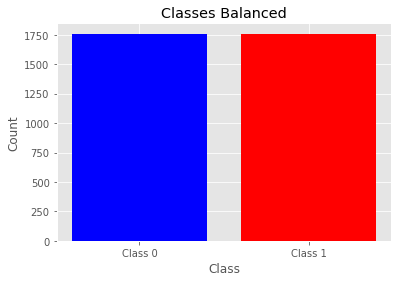

In [65]:
sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_sample(X_train, y_train)
num_class0 = len(y_train[y_train['Label'] == 0])
num_class1 = len(y_train[y_train['Label'] == 1])
# print(y_train)
# print(f'X\'s shape: {X_train.shape} y\'s shape: {y_train.shape}')
plt.bar([0, 1], [num_class0, num_class1], color=['blue', 'red'])
plt.xlabel('Class')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.ylabel('Count')
plt.title('Classes Balanced')
# plt.show()

In [73]:
# Fitting our model to data
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Performance Metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

text_file = open("Results_balanced_best.txt", "w")
text_file.write(str(metrics.classification_report(y_test, y_pred)))
text_file.write(str(metrics.confusion_matrix(y_test, y_pred)))
text_file.close()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       310
           1       0.25      0.33      0.29         3

    accuracy                           0.98       313
   macro avg       0.62      0.66      0.64       313
weighted avg       0.99      0.98      0.99       313

[[307   3]
 [  2   1]]
